In [1]:
%pylab inline
import pandas as pd
import theano
theano.config.floatX = 'float64'
import pymc3 as pm


Populating the interactive namespace from numpy and matplotlib


In [2]:
import theano.tensor as tt

In [73]:
import time

In [78]:
advi_times = []
sizes = np.linspace(20, 200000, 10)
for size in sizes:
    true_intercept = 1
    true_slope = 2

    x = np.linspace(0, 1, size)

    true_regression_line = true_intercept + true_slope * x
    y = true_regression_line + np.random.normal(scale=.5, size=size)

    data = dict(x=x, y=y)
    
    with pm.Model() as model:
        # Define priors
        sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
        intercept = pm.Normal('Intercept', 0, sd=20)
        x_coeff = pm.Normal('x', 0, sd=20)

        mu = intercept + x_coeff * x
        likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=y)

    t0 = time.time()
    with model:
        means, sds, elbos = pm.variational.advi(n=20000)
        
    advi_times.append(time.time() - t0)

/Users/vale/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Average ELBO = -30.05: 100%|██████████| 20000/20000 [00:01<00:00, 15668.21it/s] 
Finished [100%]: Average ELBO = -29.765
Average ELBO = -16,711: 100%|██████████| 20000/20000 [00:05<00:00, 3405.25it/s]   
Finished [100%]: Average ELBO = -16,384
Average ELBO = -33,637: 100%|██████████| 20000/20000 [00:10<00:00, 1908.36it/s]   
Finished [100%]: Average ELBO = -32,888
Average ELBO = -50,193: 100%|██████████| 20000/20000 [00:15<00:00, 1282.30it/s]   
Finished [100%]: Average ELBO = -49,196
Average ELBO = -67,139: 100%|██████████| 20000/20000 [00:20<00:00, 976.42it/s]   
Finished [100%]: Average ELBO = -65,887
Average ELBO = -83,476: 100%|██████████| 20000/20000 [00:26<00:00, 755.49it/s]    
Finished [100%]: Average ELBO = -81,943
Average ELBO = -1.0016e+05: 100%|██████████| 20000/20000 [00:32<00:00, 623.7

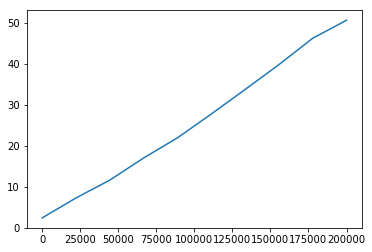

In [80]:
plt.plot(sizes, advi_times);

In [82]:
x_t = tt.vector()
x_t.tag.test_value = np.zeros(1)

y_t = tt.vector()
y_t.tag.test_value = np.zeros(1)

minibatch_tensors = [x_t, y_t]

In [83]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)
    
    mu = intercept + x_coeff * x_t
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=y_t)


In [84]:
minibatch_RVs = [likelihood]

In [85]:
def minibatch_gen(data):
    rng = np.random.RandomState(9)
    
    while True:
        ixs = rng.randint(len(data['x']), size=100)
        yield data['x'][ixs], data['y'][ixs]

In [86]:
mb_advi_times = []
for size in sizes:
    true_intercept = 1
    true_slope = 2

    x = np.linspace(0, 1, size)

    true_regression_line = true_intercept + true_slope * x
    y = true_regression_line + np.random.normal(scale=.5, size=size)

    data = dict(x=x, y=y)
    
    minibatches = minibatch_gen(data)
    
    t0 = time.time()
    means, sds, elbos = pm.variational.advi_minibatch(
        model=model, n=20000, minibatch_tensors=minibatch_tensors,
        minibatch_RVs=minibatch_RVs, minibatches=minibatches,
        total_size=len(data['x'])
    )
    
    mb_advi_times.append(time.time() - t0)

/Users/vale/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Average ELBO = -32.85: 100%|██████████| 20000/20000 [00:04<00:00, 4615.38it/s]
Finished minibatch ADVI: ELBO = -29.05
/Users/vale/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Average ELBO = -16,683.61: 100%|██████████| 20000/20000 [00:04<00:00, 4612.16it/s]
Finished minibatch ADVI: ELBO = -16,185.61
Average ELBO = -33,776.46: 100%|██████████| 20000/20000 [00:04<00:00, 4604.23it/s]
Finished minibatch ADVI: ELBO = -34,384.99
Average ELBO = -49,932.86: 100%|██████████| 20000/20000 [00:04<00:00, 4587.49it/s]
Finished minibatch ADVI: ELBO = -50,458.88
Average ELBO = -67,123.26: 100%|██████████| 20000/20000 [00:04<00:00, 4404.64it/s]
Finished minibatch ADVI: ELBO = -69,393.39
Av

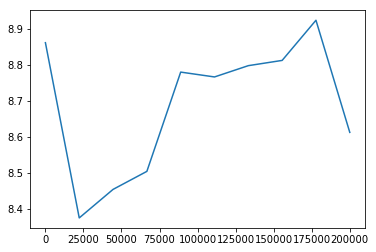

In [88]:
plt.plot(sizes, mb_advi_times);

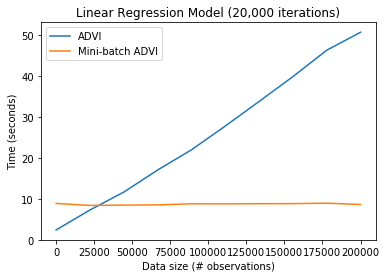

In [99]:
plt.plot(sizes, advi_times, label='ADVI');
plt.plot(sizes, mb_advi_times, label='Mini-batch ADVI');
plt.title('Linear Regression Model (20,000 iterations)');
plt.legend();
plt.xlabel('Data size (# observations)')
plt.ylabel('Time (seconds)');

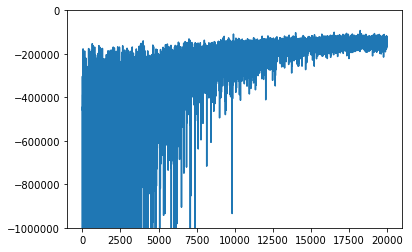

In [105]:
plt.plot(elbos)
plt.ylim(-1e6, 0);

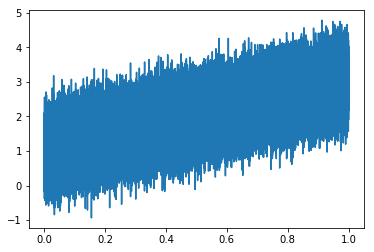

In [107]:
plt.plot(x, y);

In [108]:
means

{'Intercept': array(1.0375121604515822),
 'sigma_log_': array(-0.692413011804754),
 'x': array(1.9445221003700959)}